In [1]:
!pip install -r requirements.txt

     |████████████████████████████████| 3.3 MB 5.7 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
from nltk import sent_tokenize
from tokenizers import Tokenizer
import torch

In [4]:
df = pd.read_csv(
    'data/jd.csv', 
#     nrows=1000
)

In [5]:
df

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
...,...,...,...,...,...,...,...,...,...,...,...,...
244763,72705211,TEACHER OF SCIENCE,Position: Qualified Teacher Subject/Specialism...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk
244764,72705212,TEACHER OF BUSINESS STUDIES AND ICT,Position: Qualified Teacher or NQT Subject/Spe...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk
244765,72705213,ENGLISH TEACHER,Position: Qualified Teacher Subject/Specialism...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk
244766,72705216,SUPPLY TEACHERS,Position: Qualified Teacher Subject/Specialism...,Wiltshire,Wiltshire,NaN,contract,NaN,Teaching Jobs,450 to 500 per week,22800,hays.co.uk


In [6]:
tokenizer = Tokenizer.from_file("data/jd_tokenizer_wordpiece.json")
tokenizer.enable_padding()
tokenizer.enable_truncation(512)

In [7]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
tokenizer.encode_batch(['small sent', 'a larger sent'])

[Encoding(num_tokens=3, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=3, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]

In [9]:
import random
class DataCollatorForLanguageModeling:
    def __init__(self, tokenizer, mlm_probability=0.15):
        self.tokenizer = tokenizer
        self.mlm_probability = mlm_probability
        self.special_token_ids = []
        self.vocab_size = tokenizer.get_vocab_size()
        for i in range(len(tokenizer.get_vocab())):
            tok = tokenizer.id_to_token(i)
            if tok[0] == '[' and tok[-1] == ']':
                self.special_token_ids.append(i)
            else:
                break
        
    def __call__(self, batch):
        shape = (len(batch), len(batch[0]))
        labels = torch.full(shape, -100)
        mask = torch.full(shape, True)
#         input_ids
        for i in range(len(batch)):
            for j in range(len(batch[0])):
                tok = batch[i][j]
                if tok == 0:
                    break
                else:
                    r1 = random.random()
                    r2 = random.random()
                    if r1 < self.mlm_probability and tok not in self.special_token_ids:
                        if r2 < 0.8:
                            replacement = self.tokenizer.token_to_id('[MASK]')
                        elif r2 < 0.9:
                            replacement = random.randint(100, self.vocab_size-1)
                        else:
                            replacement = tok
                        
                        batch[i][j] = replacement
                        labels[i][j] = tok
                    else:
                        mask[i][j] = False
        
        return {
            'input_ids': torch.tensor(batch),
            'mask': mask,
            'labels': labels
        }

In [10]:
dc = DataCollatorForLanguageModeling(tokenizer, mlm_probability=0.2)

In [11]:
def get_mlm_batch(sentences):
    sentences = [f'[CLS] {s} [SEP]' for s in sentences]
    toks = tokenizer.encode_batch(
        sentences,
        add_special_tokens=True
    )
    toks = [t.ids for t in toks]
    
    return dc(toks)

In [12]:
get_mlm_batch(['this is a sent', 'this is another sent but longer'])

{'input_ids': tensor([[   2,    4,  200,   37, 4357,    3,    0,    0],
         [   2,  220,  200, 3966, 4357,  768, 4311,    3]]),
 'mask': tensor([[False,  True, False, False, False, False,  True,  True],
         [False, False, False, False, False, False, False, False]]),
 'labels': tensor([[-100,  220, -100, -100, -100, -100, -100, -100],
         [-100, -100, -100, -100, -100, -100, -100, -100]])}

In [13]:
def line_by_line_generator(jds, batch_size=32, max_length=128):
    examples = []
    ex = ''
    current_token_count = 0
    while True:
        for jd in jds:
            if len(ex) > 0:
                ex += ' [SEP] '
            sents = sent_tokenize(jd)
            for sent in sents:
                sent_len = len(sent.split())
                if current_token_count + sent_len >= max_length:
                    examples.append(ex)
                    ex = ''
                    current_token_count = 0
                    if len(examples) == batch_size:
                        batch = get_mlm_batch(examples)
                        yield batch
                        examples = []

                ex += sent
                current_token_count += sent_len

In [14]:
for index, batch in enumerate(line_by_line_generator(df.FullDescription, batch_size=4)):
    if index > 5:
        break
#     print(len(batch))
#     print(batch)

In [15]:
import torch
import math
from torch import nn, optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, emb_dimension, n_head, dropout):
        super().__init__()
        self.emb_dimension = emb_dimension
        self.n_head = n_head
        self.qw = nn.Linear(self.emb_dimension, self.emb_dimension)
        self.kw = nn.Linear(self.emb_dimension, self.emb_dimension)
        self.vw = nn.Linear(self.emb_dimension, self.emb_dimension)
        self.proj = nn.Linear(self.emb_dimension, self.emb_dimension)
        self.dropout = nn.Dropout()
        
    def forward(self, x, mask=None):
        B, T, V = x.shape
        
        q = self.qw(x).view(B, T, self.n_head, V // self.n_head).transpose(1, 2) # shape will be B, b_head, T, V // n_head
        k = self.kw(x).view(B, T, self.n_head, V // self.n_head).transpose(1, 2)
        v = self.vw(x).view(B, T, self.n_head, V // self.n_head).transpose(1, 2)
        
        
        # scaled dot attention
        att = (q @ k.transpose(-1, -2)) * (1.0 / math.sqrt(k.size(-1))) # shape will be B, n_head, T, T
        
        if mask is not None:
            mask = mask.unsqueeze(1).repeat(1, T, 1).unsqueeze(1)
            att.masked_fill_(mask, -1e9)
        
        att = torch.softmax(att, -1)
        out = att @ v
        att = self.dropout(att)
        
        out = out.transpose(1, 2)
        out = out.reshape(B, T, V)
        out = self.proj(out)
        out = self.dropout(out)
        
        return {
            'output': out,
            'mask': mask,
            'attention': att
        }

In [17]:
batch_size = 2
embedding_dim = 6
timesteps = 4
x = torch.rand((batch_size, timesteps, embedding_dim))
mask = [[True if random.random() > 0.8 else False for _ in range(timesteps)] for _ in range(batch_size)]
mask = torch.tensor(mask)
sal = SelfAttentionLayer(embedding_dim, 2, 0.0)

In [18]:
out = sal(x, mask)

In [19]:
class EncoderBlock(nn.Module):
    def __init__(self, emb_dimension=512, n_head=8, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(emb_dimension)
        self.ln2 = nn.LayerNorm(emb_dimension)
        self.dropout = nn.Dropout(dropout)
        self.self_attention = SelfAttentionLayer(emb_dimension, n_head, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(emb_dimension, 4*emb_dimension),
            nn.GELU(),
            nn.Linear(4*emb_dimension, emb_dimension),
            nn.Dropout(dropout)
        )
        
    def forward(self, x, mask=None):
        x = x + self.self_attention(self.ln1(x), mask)['output']
        x = x + self.feed_forward(self.ln2(x))
        return x

In [20]:
eb = EncoderBlock(embedding_dim, 2, 0.0)
eb(x, mask)

tensor([[[ 0.3641,  0.0990,  0.9504,  0.2047,  0.7247,  0.5811],
         [-0.6783,  0.3565, -0.0195,  0.9071,  0.9127,  2.1209],
         [ 0.6961,  0.8577,  0.4497,  0.5552,  0.9135,  1.8864],
         [ 0.3561,  0.6649,  0.7294, -0.2813,  0.5614,  2.1200]],

        [[-0.1444,  0.2995, -0.2673,  1.5892,  0.9499,  1.5313],
         [-0.1647,  0.6111,  0.3787,  0.1242,  0.4752,  1.0457],
         [ 0.2273, -0.0912,  1.2180,  0.9176,  0.8547,  1.1293],
         [-0.5180,  0.0685,  1.6853,  0.0676,  0.7560,  1.3780]]],
       grad_fn=<AddBackward0>)

In [21]:
class Transformer_MLM(nn.Module):
    def __init__(self,tokenizer=None, emb_dimension=512, n_head=8, dropout=0.1, n_layers=6):
        super().__init__()
        self.tokenizer = tokenizer
        self.token_encoder = nn.Embedding(tokenizer.get_vocab_size(), emb_dimension)
        self.position_encoder = nn.Parameter(torch.zeros(1, 512, emb_dimension).uniform_(0, 0.05))
        
        
        self.encoders = nn.ModuleList([EncoderBlock(emb_dimension, n_head, dropout) for _ in range(n_layers)])
        self.lm_head = nn.Linear(emb_dimension, tokenizer.get_vocab_size())
        
    def forward(self, x, mask=None):
        B, T = x.shape
        x_tok = self.token_encoder(x)
        x_pos = self.position_encoder[:, :T, :]
        
        x_emb = x_tok + x_pos
        
        for block in self.encoders:
            x_emb = block(x_emb, mask)
            
        out = self.lm_head(x_emb)
        return out

In [31]:
transformer_model = Transformer_MLM(tokenizer)
transformer_model.to(device)

Transformer_MLM(
  (token_encoder): Embedding(36000, 512)
  (encoders): ModuleList(
    (0): EncoderBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (self_attention): SelfAttentionLayer(
        (qw): Linear(in_features=512, out_features=512, bias=True)
        (kw): Linear(in_features=512, out_features=512, bias=True)
        (vw): Linear(in_features=512, out_features=512, bias=True)
        (proj): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
      )
      (feed_forward): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU()
        (2): Linear(in_features=2048, out_features=512, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (1): EncoderBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      

In [32]:
optimizer = optim.AdamW(transformer_model.parameters())

In [33]:
running_loss = 0.0
losses = []

In [34]:
tokenizer.encode("thiss").ids

[220, 118]

In [35]:
tokenizer.decode([220, 118])

'this ##s'

In [ ]:
accumulation_steps = 8
transformer_model.train()
for index, batch in enumerate(line_by_line_generator(df.FullDescription.sample(frac=1.0), batch_size=8, max_length=128)):
    if index > 50000:
        break

    inp = batch['input_ids'].to(device)
    labels = batch['labels'].to(device)
    
    output = transformer_model(inp)
    output_shape = output.shape
    loss_all = F.cross_entropy(output.view(-1, output_shape[-1]), labels.view(-1), reduction='none')
    loss = loss_all[loss_all > 0].mean()
    lit = loss.item()
    losses.append(lit)
    running_loss = 0.9 * running_loss + 0.1 * lit
    if index % 25 == 0:
        print(f'Running loss at {index} is {running_loss}')
    
    loss = loss / accumulation_steps
    loss.backward()
    if (index+1) % accumulation_steps == 0:  
        optimizer.step()
        optimizer.zero_grad()


Running loss at 0 is 5.0358940937915255
Running loss at 25 is 4.73713755090494
Running loss at 50 is 4.793367494528374
Running loss at 75 is 4.705108485822459
Running loss at 100 is 4.73905204824572
Running loss at 125 is 4.910830560440085
Running loss at 150 is 4.669873943266832
Running loss at 175 is 4.781158874534393
Running loss at 200 is 4.804618103764698
Running loss at 225 is 4.749888803131924
Running loss at 250 is 4.701550490534748
Running loss at 275 is 4.7183380647396564
Running loss at 300 is 4.74727362185067
Running loss at 325 is 4.766252402355877
Running loss at 350 is 4.836884506473715
Running loss at 375 is 4.748392125066183
Running loss at 400 is 4.775037403746823
Running loss at 425 is 4.721591000983358
Running loss at 450 is 4.768648720401286
Running loss at 475 is 4.7026793678066925
Running loss at 500 is 4.685111737477078
Running loss at 525 is 4.748058804007624
Running loss at 550 is 4.726923407599834
Running loss at 575 is 4.756959985523662
Running loss at 600 i

In [55]:
(loss_all > 0).sum()

tensor(284, device='cuda:0')

In [56]:
loss_all[loss_all>0].sort()

torch.return_types.sort(
values=tensor([1.0323e-04, 1.5722e-04, 9.6846e-04, 1.5454e-03, 3.1191e-03, 3.9472e-03,
        1.6362e-02, 3.0010e-02, 3.2247e-02, 1.2260e-01, 1.5431e-01, 1.8654e-01,
        2.7251e-01, 3.7736e-01, 3.8077e-01, 9.1883e-01, 1.0843e+00, 1.1882e+00,
        1.5827e+00, 1.6409e+00, 1.7808e+00, 1.8598e+00, 1.9958e+00, 2.0038e+00,
        2.0543e+00, 2.0925e+00, 2.1903e+00, 2.2966e+00, 2.3017e+00, 2.3953e+00,
        2.4019e+00, 2.4454e+00, 2.5734e+00, 2.5958e+00, 2.6387e+00, 2.6436e+00,
        2.6500e+00, 2.6778e+00, 2.6826e+00, 2.7486e+00, 2.8646e+00, 2.9105e+00,
        2.9994e+00, 3.1524e+00, 3.1625e+00, 3.1645e+00, 3.1980e+00, 3.3089e+00,
        3.4043e+00, 3.4289e+00, 3.5002e+00, 3.5002e+00, 3.5256e+00, 3.5302e+00,
        3.5569e+00, 3.5624e+00, 3.5683e+00, 3.5840e+00, 3.5885e+00, 3.6162e+00,
        3.6367e+00, 3.6766e+00, 3.6782e+00, 3.6893e+00, 3.7053e+00, 3.7538e+00,
        3.7933e+00, 3.8246e+00, 3.9248e+00, 3.9422e+00, 3.9828e+00, 4.0101e+00,
        

In [57]:
def save_model(model, PATH):
    torch.save(model.state_dict(), PATH)
    
def load_model(PATH):
    model = RNN_MLM(tokenizer)
    model.load_state_dict(torch.load(PATH, map_location=device))
    model.eval()
    return model

In [58]:
# save_model(rnn_mlm_model, 'models/rnn_6_786_bi_wordpiece.pt')
# rnn_mlm_model = load_model('models/rnn_4_bi_wordpiece.pt')

In [59]:
loss

tensor(0.8004, device='cuda:0', grad_fn=<DivBackward0>)

In [60]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from plotly import express as px

<AxesSubplot:>

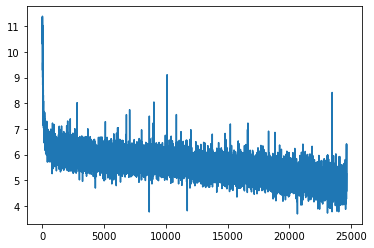

In [61]:
ls = pd.Series(losses)
ls.plot()

In [62]:
transformer_model.eval()

Transformer_MLM(
  (token_encoder): Embedding(36000, 512)
  (encoders): ModuleList(
    (0): EncoderBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (self_attention): SelfAttentionLayer(
        (qw): Linear(in_features=512, out_features=512, bias=True)
        (kw): Linear(in_features=512, out_features=512, bias=True)
        (vw): Linear(in_features=512, out_features=512, bias=True)
        (proj): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
      )
      (feed_forward): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU()
        (2): Linear(in_features=2048, out_features=512, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (1): EncoderBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      

In [63]:
df[df.Title.notnull() & df.Title.str.contains('Software Developer')].iloc[0]['FullDescription']

'C Developer Belfast Salary up to ****k pa Our client, a leading edge Software Development Centre in Belfast requires C Developers to deliver key software products directly for their clients and for their business teams using the latest Microsoft technologies (.NET C, ASP.NET and SQL Server). Key Accountabilities • Design and develop cuttingedge software solutions, developed in C .Net with SQL as the back end data store. • Ensure all deliverables for projects are completed on time, to budget and within quality standards. • Assist the Project Manager in production of estimates for development activity. • Work with the Business and Data Analysts to drive the requirements forward. • Provide support and consultancy across all test phases of the project. • Participation in planning of software releases, their execution and postrelease activities. • Assist with maintenance and production support. • Support colleagues through advice and technical assistance. Key Technical Skills • A degree in

In [64]:
para = """Designation: Python Distributed [MASK] Engineer
Educational Qualifications: B.Tech/M.Tech/MS/MCA
Experience: 3-9 Years
What you will do
Apply your [MASK] set to fetch data from [MASK] online web sources, cleanse it and [MASK] APIs on top of it.
Work with [MASK] databases (MongoDB) to store raw/document-based data.
Develop a deep [MASK] of our vast data sources on the web and know exactly how, when, and which data to scrape, parse and store.
Develop [MASK] for automating and maintaining a [MASK] flow of data from multiple sources.
Work independently with little supervision to research and test [MASK] solutions.
What you will need
Strong coding [MASK] in Python and [MASK] Web Framework.
Information retrieval – Web [MASK].
Experience with NoSQL data storage like [MASK].
Good knowledge of Asynchronous task [MASK] like Celery.
Experience working with large scale [MASK] and storage.
Knowledge of [MASK] with Node.js is a plus.
Knowledge of [MASK] with various front end technologies and how various websites are built.
Sound [MASK] of Asynchronous Programming in python like AsyncIO."""
# para = para.replace('\n', ' ')
toks = tokenizer.encode(f'[CLS] {para} [SEP]')
toks = torch.tensor([toks.ids]).to(device)

In [65]:
output = transformer_model(toks)
output = output.argmax(dim=-1)[0].cpu()

In [66]:
tokenizer.decode(output.numpy()).replace(' ##', '')

'defendant responsibilities : python engineer : engineer educational qualifications : b . tech / m . tech / ms / / experience : 3 3 9 years what you will do apply your . set to and data from and online web sources , cleanse it and the apis on top of it . work with the databases ( mongodb ) to store raw / document and based data . develop a deep and of our vast data sources on the web and know exactly how , when , and which data to ande , andse and store . develop and for automating and maintaining a and flow of data from multiple sources . work independently with little supervision to research and test and solutions . what you will need strong coding be in python and be web framework . information a – web and . experience with web data storage like and . good knowledge of experience task and like ay . experience working with large scale and and storage . knowledge of and with css . js is a plus . knowledge of and with various front end technologies and how various websites are built . 

In [51]:
# df[df.FullDescription.str.contains('data science')]

In [57]:
df.FullDescription[5500]

'Location  Leeds. My client, an established and growing IT company are currently recruiting for a Telemarketing Executive. This is an exciting new business sales opportunity to join a forward thinking organisation that continues to go from strength to strength. The Telemarketing Executive role offers an excellent platform for progression to Senior Account Manager. Role Profile: The Telemarketer function is a key position to feed the growth objectives of the organisation. The intention of this position is to drive new clients to a Workshop and/or contact new clients on a range of specific products and service offerings on a project by project basis. The position is a training ground to further graduate onto junior account manager role after approximately ****2 months. It is expected that you will be capable of using the phone and email to convey value of the workshop or project with a qualified decision maker. Key Responsibilities: Your main targets will include: Ability to make **** ou

In [ ]:
torch.cuda.empty_cache()

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [52]:
import gc
# del rnn_mlm_model
# del optimizer
gc.collect()

38

In [ ]:
batch['input_ids'].shape

In [ ]:
output.view(-1, output.shape[-1]).shape

In [ ]:
labels.shape

In [ ]:
out = rnn_mlm_model(batch['input_ids'])

In [ ]:
running_loss = 0.0